# MillenniumAI performance comparison

## Set executable paths

In [1]:
import sys
import networkx as nx
import matplotlib.pyplot as plt
import os
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.loader import NeighborLoader
import torch
import subprocess
from typing import Tuple, List, Dict
import socket
import pickle
import time
import tracemalloc

# Necessary to import from sibling directory
sys.path.append("..")


from pymdb import (
    MDBClient,
    EvalGraphLoader,
    SamplingGraphLoader,
    Sampler,
)

In [2]:
# Path to MillenniumDB/MillenniumAI executables
SERVER_PYMDB_PATH = "/home/mdbai/MillenniumDB-Dev/build/Release/bin/server_pymdb"
CREATE_DB_PATH = "/home/mdbai/MillenniumDB-Dev/build/Release/bin/create_db"
GENERATION_BASE_PATH = "/home/mdbai/PyMDB/examples/generated"

if not os.path.exists(SERVER_PYMDB_PATH):
    raise Exception(
        "SERVER_PYMDB_PATH is not set to the correct path. "
        "Please set it to the path of the MillenniumDB server_pymdb executable."
    )

if not os.path.exists(CREATE_DB_PATH):
    raise Exception(
        "CREATE_DB_PATH is not set to the correct path. "
        "Please set it to the path of the MillenniumDB create_db executable."
    )

# Port to run MillenniumDB server on
SERVER_PORT = 8080

## Define performance test function

In [3]:
# Generate graphs in multiple formats. Returns the necessary data of each one
def generate_graphs(
    num_nodes: int,
    num_edges: int,
    num_node_feat: int,
) -> Tuple[Data, str]:
    graph_name = f"N{num_nodes}_E{num_edges}_F{num_node_feat}"
    
    # In-memory graph
    pickle_path = f"{GENERATION_BASE_PATH}/{graph_name}.pkl"
    if os.path.exists(pickle_path):
        # Load a graph from an existing pickle
        print("  Pickle graph dump already exists. Loading file...")
        graph = pickle.load(open(pickle_path, "rb"))
    else:
        # Generate a new graph and dump to a pickle
        print("  Generating a new randomized graph...")
        graph = from_networkx(
            nx.gnm_random_graph(num_nodes, num_edges, seed=2023, directed=True)
        )
        graph.node_feat = torch.rand(num_nodes, num_node_feat, dtype=torch.float32)
        print("  Writing the generated graph to a pickle...")
        pickle.dump(graph, open(pickle_path, "wb"))

    # On-disk MillenniumDB graph
    mdb_dump_path = f"{GENERATION_BASE_PATH}/{graph_name}.milldb"
    if os.path.exists(mdb_dump_path):
        # Skip MDB dump creation
        print("  MillenniumDB's graph dump already exists. Skipping dump creation...")
    else:
        with open(mdb_dump_path, "w") as f:
            for idx in range(graph.num_nodes):
                f.write(f"N{idx} feat:{graph.node_feat[idx].tolist()}\n")
            for edge in graph.edge_index.T:
                f.write(f"N{edge[0]}->N{edge[1]} :T\n")

    return graph, mdb_dump_path


# Create a MillenniumDB database from a file in the current directory and return its path
def create_db(mdb_dump_path: str) -> str:
    dest_path = mdb_dump_path.replace(".milldb", "")
    
    if os.path.isdir(dest_path):
        print("  MillenniumDB's database already exists. Skipping database creation...")
    else:
        print("  Creating MillenniumDB's database...")
        result = subprocess.run(
            [CREATE_DB_PATH, mdb_dump_path, dest_path],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.PIPE,
        )
        if result.returncode != 0:
            raise RuntimeError(f"create_db: {result.stderr.decode('utf-8')}")
    return dest_path


# Start a MillenniumDB server for a given database directory
def start_server(db_path: str):
    process = subprocess.Popen(
        [SERVER_PYMDB_PATH, db_path, "-p", str(SERVER_PORT)],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.PIPE,
    )

    # Wait for server to listen to port
    while socket.socket().connect_ex(("localhost", SERVER_PORT)) != 0:
        time.sleep(0.5)

    return process


# Kill a MillenniumDB server process and return its exit code
def kill_server(process) -> int:
    process.kill()
    return process.wait()

# Clear both buffer/cache and swap of the OS
def clear_os():
    os.system("sudo sync && echo 3 | sudo tee /proc/sys/vm/drop_caches > /dev/null")
    os.system("sudo swapoff -a && sudo swapon -a")

# Get the a in-memory graph memory estimation in MB (node_features + edge_index)
def graph_size(graph):
    return (graph.node_feat.numel() * 4 + graph.edge_index.numel() * 8) / 1e6

# Run performance tests for a list of instances and a list of batch sizes
def run_performance_tests(instances: List[Dict], batch_sizes: List[int]):
    if not os.path.exists(GENERATION_BASE_PATH):
        os.makedirs(GENERATION_BASE_PATH)

    plot_data = dict()

    for instance in instances:
        print(f"Running for instance: {instance}...")
        # Generate graphs
        graph, mdb_dump_path = generate_graphs(**instance)
        db_path = create_db(mdb_dump_path)

        plot_data[db_path] = {
            "time_mem": list(), 
            "time_mdb": list(),
            "mempeak_mem": list(),
            "mempeak_mdb": list(),
            "batch_size": list(),
        }
        for batch_size in batch_sizes:
            print(f"    Running for batch size: {batch_size}...")
            plot_data[db_path]["batch_size"].append(batch_size)
            
            
            # 1. In-memory graph
            clear_os()
            tracemalloc.start()
            t0_mem = time.perf_counter_ns()
            for batch in NeighborLoader(
                graph, num_neighbors=[5, 5], batch_size=batch_size
            ):
                # Here the batch would be passed to a model
                pass
            plot_data[db_path]["time_mem"].append((time.perf_counter_ns() - t0_mem) / 1e9)
            _, peak = tracemalloc.get_traced_memory()
            plot_data[db_path]["mempeak_mem"].append((peak / 1e6) + graph_size(graph))
            tracemalloc.stop()
            
            
            # 2. MillenniumDB graph
            clear_os()
            tracemalloc.start()
            server_process = start_server(db_path)
            with MDBClient("localhost", SERVER_PORT) as client:
                t0_mdb = time.perf_counter_ns()
                for batch in EvalGraphLoader(
                    client, num_neighbors=[5, 5], batch_size=batch_size
                ):
                    # Here the batch would be passed to a model
                    pass
                plot_data[db_path]["time_mdb"].append((time.perf_counter_ns() - t0_mdb) / 1e9)
                _, peak = tracemalloc.get_traced_memory()
                plot_data[db_path]["mempeak_mdb"].append(peak / 1e6)
                tracemalloc.stop()
            kill_server(server_process)

    return plot_data

## Run performance tests for instances

In [4]:
instances = [
    {"num_nodes": 9_000,      "num_edges": 10_000,     "num_node_feat": 4},
    {"num_nodes": 90_000,     "num_edges": 100_000,    "num_node_feat": 4},
    {"num_nodes": 900_000,    "num_edges": 1_000_000,  "num_node_feat": 4},
    {"num_nodes": 1_800_000,  "num_edges": 2_000_000,  "num_node_feat": 4},
    {"num_nodes": 3_600_000,  "num_edges": 4_000_000,  "num_node_feat": 4},
    {"num_nodes": 7_200_000,  "num_edges": 8_000_000,  "num_node_feat": 4},
    {"num_nodes": 14_400_000, "num_edges": 16_000_000, "num_node_feat": 4},
]
args = {
    "instances": instances, 
    "batch_sizes": [1_024, 2_048, 4_096, 8_192]
}

plot_data = run_performance_tests(**args)

Running for instance: {'num_nodes': 9000, 'num_edges': 10000, 'num_node_feat': 4}...
  Pickle graph dump already exists. Loading file...
  MillenniumDB's graph dump already exists. Skipping dump creation...
  MillenniumDB's database already exists. Skipping database creation...
    Running for batch size: 1024...
    Running for batch size: 2048...
    Running for batch size: 4096...
    Running for batch size: 8192...
Running for instance: {'num_nodes': 90000, 'num_edges': 100000, 'num_node_feat': 4}...
  Pickle graph dump already exists. Loading file...
  MillenniumDB's graph dump already exists. Skipping dump creation...
  MillenniumDB's database already exists. Skipping database creation...
    Running for batch size: 1024...
    Running for batch size: 2048...
    Running for batch size: 4096...
    Running for batch size: 8192...
Running for instance: {'num_nodes': 900000, 'num_edges': 1000000, 'num_node_feat': 4}...
  Pickle graph dump already exists. Loading file...
  Millenniu

In [5]:
def plot_comparison(x: List, y1: List, y2: List, x_label: str, y_label: str, title: str):
    plt.plot(x, y1, label="In-memory")
    plt.plot(x, y2, label="MillenniumDB")
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [6]:
print(plot_data)

{'/home/mdbai/PyMDB/examples/generated/N9000_E10000_F4': {'time_mem': [0.599395067, 0.041784099, 0.04791147, 0.043871791], 'time_mdb': [0.796352473, 0.457523885, 0.285711647, 0.267899952], 'mempeak_mem': [0.481117, 0.460428, 0.605132, 0.8850439999999999], 'mempeak_mdb': [0.720852, 1.217107, 1.940443, 1.98547], 'batch_size': [1024, 2048, 4096, 8192]}, '/home/mdbai/PyMDB/examples/generated/N90000_E100000_F4': {'time_mem': [0.311088655, 0.242676016, 0.236825377, 0.225268794], 'time_mdb': [6.868171586, 4.556531988, 3.023058254, 2.360264574], 'mempeak_mem': [3.131592, 3.202151, 3.36634, 3.695428], 'mempeak_mdb': [0.840243, 1.625195, 3.100123, 5.783179], 'batch_size': [1024, 2048, 4096, 8192]}, '/home/mdbai/PyMDB/examples/generated/N900000_E1000000_F4': {'time_mem': [3.066260201, 2.709829995, 2.484775666, 2.510222091], 'time_mdb': [69.724549194, 46.67653948, 29.648036216, 26.042669595], 'mempeak_mem': [30.49042, 30.554924, 30.700788, 30.997107999999997], 'mempeak_mdb': [0.869851, 1.702815, 3

### Time vs Batch Size

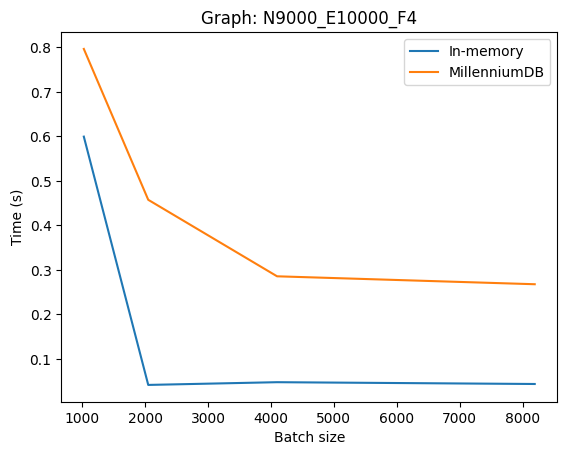

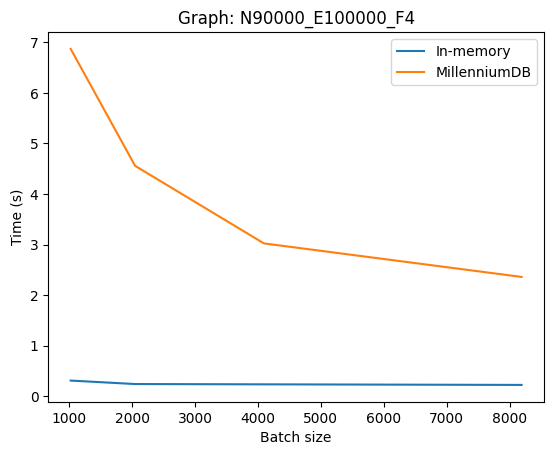

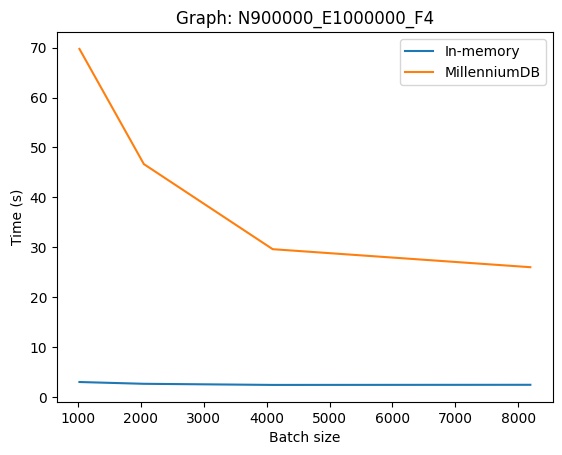

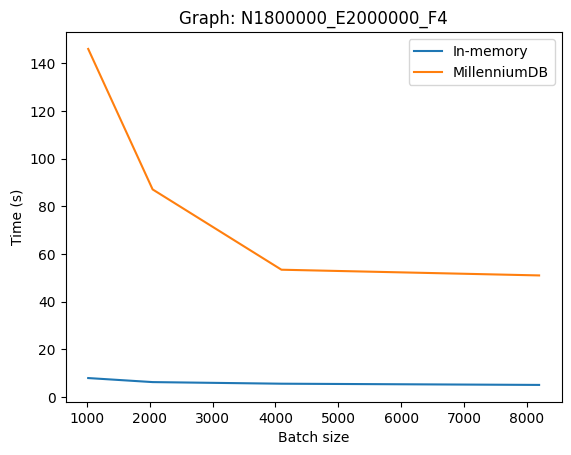

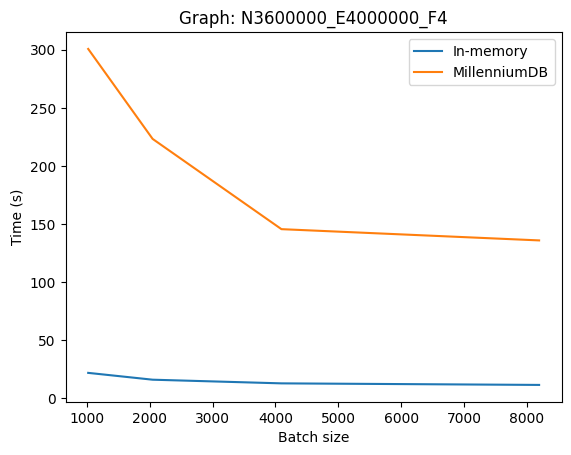

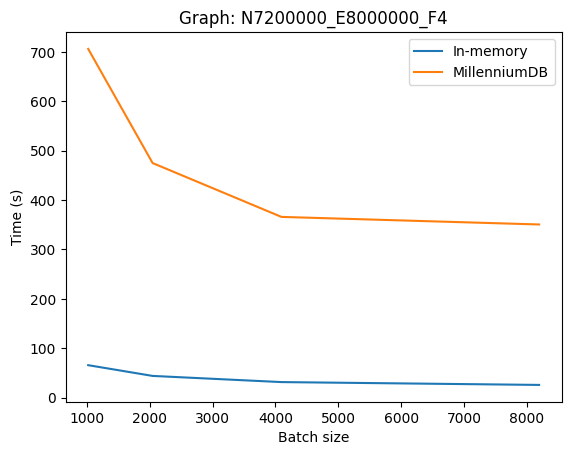

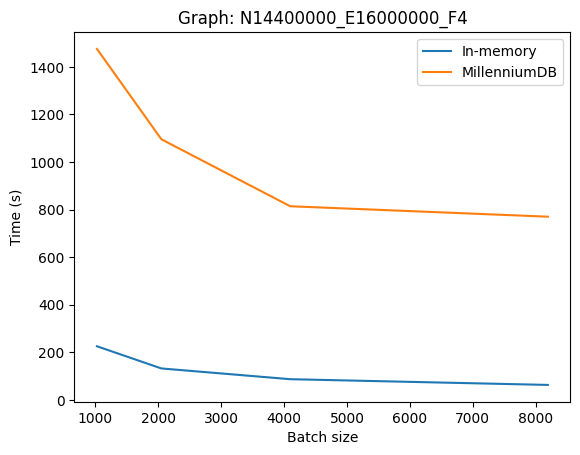

In [7]:
# Compare time over graph size
for db_path, data in plot_data.items():
    plot_comparison(
        data["batch_size"],
        data["time_mem"],
        data["time_mdb"],
        "Batch size",
        "Time (s)",
        f"Graph: {os.path.basename(db_path)}",
    )

### Peak memory usage

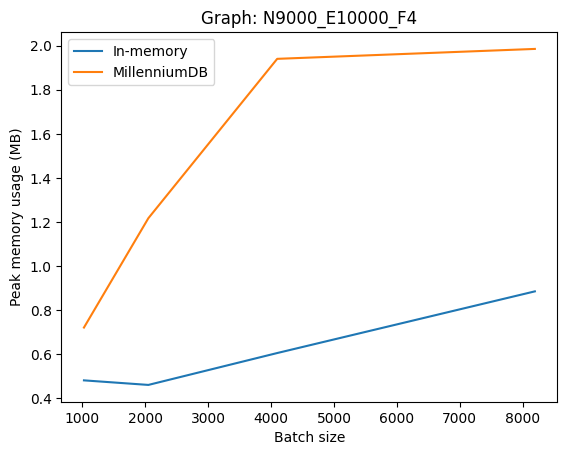

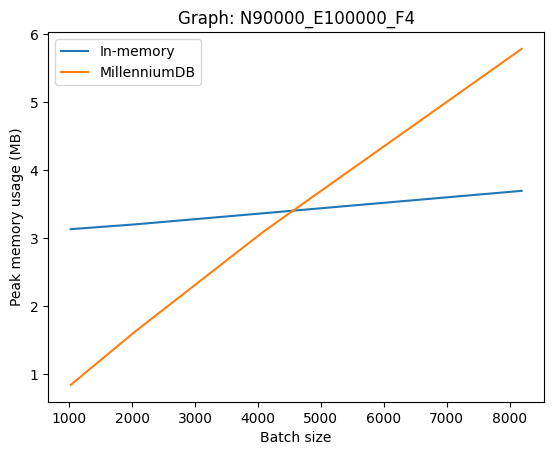

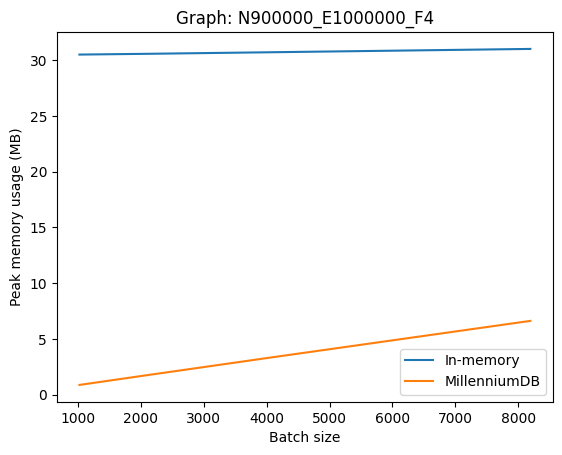

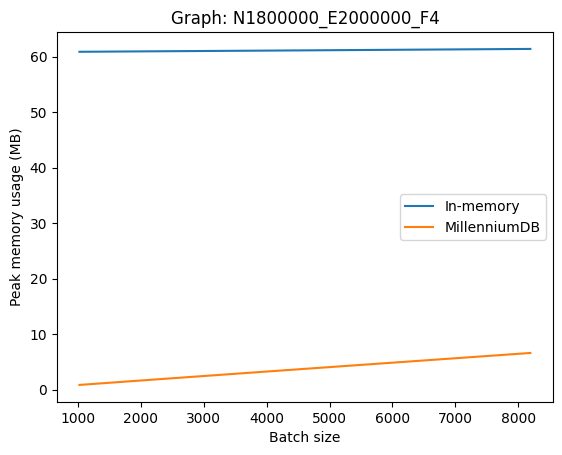

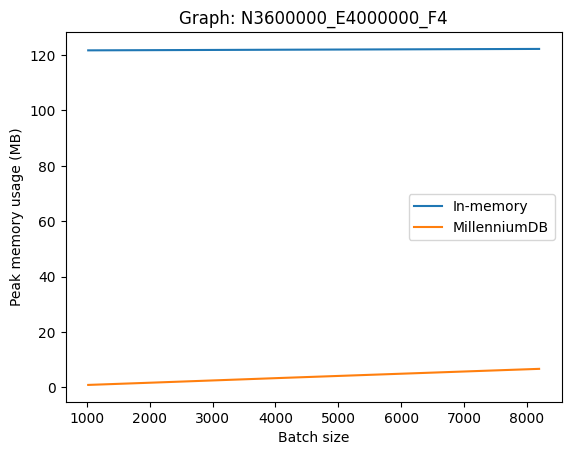

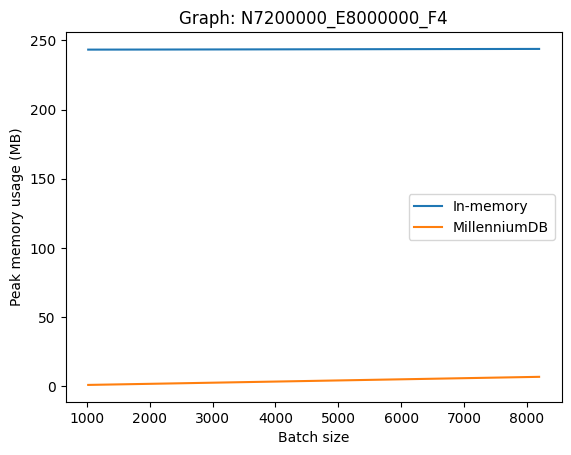

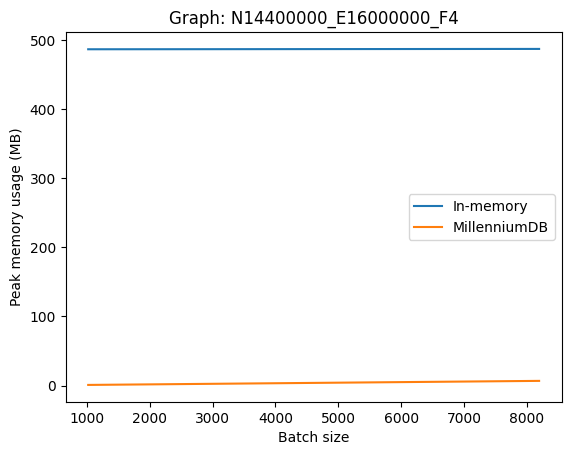

In [8]:
# Compare time over graph size
for db_path, data in plot_data.items():
    plot_comparison(
        data["batch_size"],
        data["mempeak_mem"],
        data["mempeak_mdb"],
        "Batch size",
        "Peak memory usage (MB)",
        f"Graph: {os.path.basename(db_path)}",
    )

### Cold storage size